<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:10:12] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


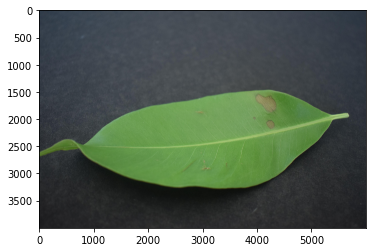

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

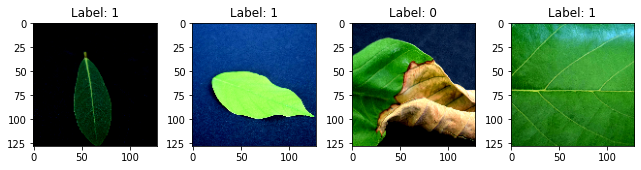

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:20] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:22] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2588105852474731 samples/sec                   batch loss = 1.1624621152877808 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2756200196088792 samples/sec                   batch loss = 0.970587432384491 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2664590375941076 samples/sec                   batch loss = 0.5442399382591248 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2659529370680767 samples/sec                   batch loss = 0.6465364694595337 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2705422768503014 samples/sec                   batch loss = 0.8248322606086731 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2679963489551767 samples/sec                   batch loss = 0.6235421895980835 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2711503796922836 samples/sec                   batch loss = 0.4032627046108246 | accuracy = 0.6214285714285714


Epoch[1] Batch[40] Speed: 1.2658772861063137 samples/sec                   batch loss = 0.6244307160377502 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2700863650637102 samples/sec                   batch loss = 1.1818737983703613 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.265528186209247 samples/sec                   batch loss = 0.8422331809997559 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2657855045924027 samples/sec                   batch loss = 0.7185177206993103 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.266554358957131 samples/sec                   batch loss = 0.413840115070343 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.265040761732184 samples/sec                   batch loss = 0.85268235206604 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.270437022588908 samples/sec                   batch loss = 0.5200872421264648 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2693794836657168 samples/sec                   batch loss = 0.5348606109619141 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.2628871621046895 samples/sec                   batch loss = 2.184932231903076 | accuracy = 0.6125


Epoch[1] Batch[85] Speed: 1.2644711764276726 samples/sec                   batch loss = 0.5052707195281982 | accuracy = 0.6088235294117647


Epoch[1] Batch[90] Speed: 1.2727697835886806 samples/sec                   batch loss = 0.6117088198661804 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.2646525604606873 samples/sec                   batch loss = 0.4190100133419037 | accuracy = 0.6210526315789474


Epoch[1] Batch[100] Speed: 1.2732596081215872 samples/sec                   batch loss = 1.0120995044708252 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.2672153103802912 samples/sec                   batch loss = 0.592515766620636 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.2695114596583252 samples/sec                   batch loss = 0.6630530953407288 | accuracy = 0.6363636363636364


Epoch[1] Batch[115] Speed: 1.2748110622419988 samples/sec                   batch loss = 0.6939331293106079 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.273223276106945 samples/sec                   batch loss = 1.0996840000152588 | accuracy = 0.6354166666666666


Epoch[1] Batch[125] Speed: 1.2697482015096315 samples/sec                   batch loss = 0.5823281407356262 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.2671998047070614 samples/sec                   batch loss = 1.2623066902160645 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2655757273289325 samples/sec                   batch loss = 0.3546677529811859 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2666470170420228 samples/sec                   batch loss = 1.0274614095687866 | accuracy = 0.6303571428571428


Epoch[1] Batch[145] Speed: 1.2693791955385494 samples/sec                   batch loss = 0.25894761085510254 | accuracy = 0.6293103448275862


Epoch[1] Batch[150] Speed: 1.2698559367479558 samples/sec                   batch loss = 0.2508253753185272 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.27367738198404 samples/sec                   batch loss = 0.5899189710617065 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.2650209215495052 samples/sec                   batch loss = 0.28349024057388306 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.269588890661328 samples/sec                   batch loss = 0.7010574340820312 | accuracy = 0.6393939393939394


Epoch[1] Batch[170] Speed: 1.267179801034864 samples/sec                   batch loss = 0.31098923087120056 | accuracy = 0.638235294117647


Epoch[1] Batch[175] Speed: 1.2662851632643002 samples/sec                   batch loss = 0.5218583941459656 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2717057563785148 samples/sec                   batch loss = 0.6236613988876343 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.273125499175708 samples/sec                   batch loss = 0.497503399848938 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.2678939115123165 samples/sec                   batch loss = 0.5156145095825195 | accuracy = 0.6473684210526316


Epoch[1] Batch[195] Speed: 1.2646908836613193 samples/sec                   batch loss = 0.8219584226608276 | accuracy = 0.6461538461538462


Epoch[1] Batch[200] Speed: 1.2651719324424833 samples/sec                   batch loss = 0.9453526139259338 | accuracy = 0.64375


Epoch[1] Batch[205] Speed: 1.2640795149047124 samples/sec                   batch loss = 0.5802897214889526 | accuracy = 0.6426829268292683


Epoch[1] Batch[210] Speed: 1.2726999773409675 samples/sec                   batch loss = 0.4511382281780243 | accuracy = 0.6440476190476191


Epoch[1] Batch[215] Speed: 1.2683510310766573 samples/sec                   batch loss = 0.37953808903694153 | accuracy = 0.6476744186046511


Epoch[1] Batch[220] Speed: 1.2689565578009192 samples/sec                   batch loss = 0.5347153544425964 | accuracy = 0.6488636363636363


Epoch[1] Batch[225] Speed: 1.274362342800348 samples/sec                   batch loss = 0.321011483669281 | accuracy = 0.6477777777777778


Epoch[1] Batch[230] Speed: 1.267623188388277 samples/sec                   batch loss = 0.5345088839530945 | accuracy = 0.6456521739130435


Epoch[1] Batch[235] Speed: 1.2734406226958703 samples/sec                   batch loss = 0.7423783540725708 | accuracy = 0.6468085106382979


Epoch[1] Batch[240] Speed: 1.270153865534856 samples/sec                   batch loss = 0.47246962785720825 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.2689256535011557 samples/sec                   batch loss = 0.4270383417606354 | accuracy = 0.6448979591836734


Epoch[1] Batch[250] Speed: 1.2688060814785813 samples/sec                   batch loss = 1.1620700359344482 | accuracy = 0.645


Epoch[1] Batch[255] Speed: 1.270577397554437 samples/sec                   batch loss = 0.7576629519462585 | accuracy = 0.6490196078431373


Epoch[1] Batch[260] Speed: 1.265937175705396 samples/sec                   batch loss = 1.0213508605957031 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2660135025615749 samples/sec                   batch loss = 1.2624434232711792 | accuracy = 0.65


Epoch[1] Batch[270] Speed: 1.26651515786319 samples/sec                   batch loss = 0.4532303512096405 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.2667016237687154 samples/sec                   batch loss = 0.3483997881412506 | accuracy = 0.6554545454545454


Epoch[1] Batch[280] Speed: 1.2635737913601948 samples/sec                   batch loss = 0.24494463205337524 | accuracy = 0.6580357142857143


Epoch[1] Batch[285] Speed: 1.269435863064916 samples/sec                   batch loss = 0.29174375534057617 | accuracy = 0.6605263157894737


Epoch[1] Batch[290] Speed: 1.2679134586332406 samples/sec                   batch loss = 0.582142174243927 | accuracy = 0.6620689655172414


Epoch[1] Batch[295] Speed: 1.2668533231988386 samples/sec                   batch loss = 0.9217700362205505 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.267253597618437 samples/sec                   batch loss = 0.5488077998161316 | accuracy = 0.6591666666666667


Epoch[1] Batch[305] Speed: 1.2676272110278597 samples/sec                   batch loss = 0.5236092805862427 | accuracy = 0.660655737704918


Epoch[1] Batch[310] Speed: 1.2651798512541084 samples/sec                   batch loss = 0.681570827960968 | accuracy = 0.6612903225806451


Epoch[1] Batch[315] Speed: 1.2673310406295344 samples/sec                   batch loss = 1.0152587890625 | accuracy = 0.6626984126984127


Epoch[1] Batch[320] Speed: 1.2684824096636595 samples/sec                   batch loss = 0.4626995921134949 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.2663329524394955 samples/sec                   batch loss = 0.3993547558784485 | accuracy = 0.6653846153846154


Epoch[1] Batch[330] Speed: 1.2737392690727227 samples/sec                   batch loss = 0.30178287625312805 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2696051273921138 samples/sec                   batch loss = 0.22490476071834564 | accuracy = 0.6723880597014925


Epoch[1] Batch[340] Speed: 1.2677945562991546 samples/sec                   batch loss = 0.3636448383331299 | accuracy = 0.6720588235294118


Epoch[1] Batch[345] Speed: 1.2689383221624784 samples/sec                   batch loss = 1.0055497884750366 | accuracy = 0.6717391304347826


Epoch[1] Batch[350] Speed: 1.2662475079351723 samples/sec                   batch loss = 0.2602049708366394 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.270865941920576 samples/sec                   batch loss = 0.5889241099357605 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2671267800024486 samples/sec                   batch loss = 0.13662216067314148 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.2736323242310195 samples/sec                   batch loss = 0.5426813960075378 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.2667179780128315 samples/sec                   batch loss = 0.170559823513031 | accuracy = 0.675


Epoch[1] Batch[375] Speed: 1.2684779979702496 samples/sec                   batch loss = 0.36335691809654236 | accuracy = 0.6753333333333333


Epoch[1] Batch[380] Speed: 1.2650506820569005 samples/sec                   batch loss = 0.4169422686100006 | accuracy = 0.6763157894736842


Epoch[1] Batch[385] Speed: 1.2668665244892785 samples/sec                   batch loss = 0.4601539075374603 | accuracy = 0.6779220779220779


Epoch[1] Batch[390] Speed: 1.2698397897135445 samples/sec                   batch loss = 0.34583789110183716 | accuracy = 0.6801282051282052


Epoch[1] Batch[395] Speed: 1.2717405558352637 samples/sec                   batch loss = 0.4052954912185669 | accuracy = 0.680379746835443


Epoch[1] Batch[400] Speed: 1.2703383264853916 samples/sec                   batch loss = 0.3066137433052063 | accuracy = 0.68125


Epoch[1] Batch[405] Speed: 1.2639701864484583 samples/sec                   batch loss = 0.5237571001052856 | accuracy = 0.6833333333333333


Epoch[1] Batch[410] Speed: 1.2717937708756988 samples/sec                   batch loss = 0.5130898952484131 | accuracy = 0.6853658536585366


Epoch[1] Batch[415] Speed: 1.2669447812658607 samples/sec                   batch loss = 0.4745878577232361 | accuracy = 0.6855421686746987


Epoch[1] Batch[420] Speed: 1.2653906425653467 samples/sec                   batch loss = 0.24322883784770966 | accuracy = 0.6892857142857143


Epoch[1] Batch[425] Speed: 1.2696159841360963 samples/sec                   batch loss = 0.8127034902572632 | accuracy = 0.6894117647058824


Epoch[1] Batch[430] Speed: 1.2661036928366485 samples/sec                   batch loss = 0.4480300545692444 | accuracy = 0.6901162790697675


Epoch[1] Batch[435] Speed: 1.2659156835705772 samples/sec                   batch loss = 0.6121776700019836 | accuracy = 0.6896551724137931


Epoch[1] Batch[440] Speed: 1.2686373179188233 samples/sec                   batch loss = 0.6626142263412476 | accuracy = 0.6886363636363636


Epoch[1] Batch[445] Speed: 1.271853353868304 samples/sec                   batch loss = 0.30966272950172424 | accuracy = 0.6882022471910112


Epoch[1] Batch[450] Speed: 1.2658169246529856 samples/sec                   batch loss = 0.3716505765914917 | accuracy = 0.6877777777777778


Epoch[1] Batch[455] Speed: 1.2727518244033231 samples/sec                   batch loss = 0.05729348212480545 | accuracy = 0.6884615384615385


Epoch[1] Batch[460] Speed: 1.2665460404733893 samples/sec                   batch loss = 0.06403922289609909 | accuracy = 0.6891304347826087


Epoch[1] Batch[465] Speed: 1.2635511422838779 samples/sec                   batch loss = 0.7762457132339478 | accuracy = 0.6865591397849462


Epoch[1] Batch[470] Speed: 1.2657084413224156 samples/sec                   batch loss = 0.5271844863891602 | accuracy = 0.6872340425531915


Epoch[1] Batch[475] Speed: 1.267977470090643 samples/sec                   batch loss = 1.1113801002502441 | accuracy = 0.6868421052631579


Epoch[1] Batch[480] Speed: 1.2627885899935474 samples/sec                   batch loss = 0.9067674875259399 | accuracy = 0.6869791666666667


Epoch[1] Batch[485] Speed: 1.2678568311302492 samples/sec                   batch loss = 0.4903949499130249 | accuracy = 0.6876288659793814


Epoch[1] Batch[490] Speed: 1.2659020245041734 samples/sec                   batch loss = 0.3820253014564514 | accuracy = 0.6877551020408164


Epoch[1] Batch[495] Speed: 1.2638799190169028 samples/sec                   batch loss = 1.1648845672607422 | accuracy = 0.6863636363636364


Epoch[1] Batch[500] Speed: 1.267124004655452 samples/sec                   batch loss = 0.7349968552589417 | accuracy = 0.686


Epoch[1] Batch[505] Speed: 1.268088259681057 samples/sec                   batch loss = 0.4954155385494232 | accuracy = 0.6846534653465347


Epoch[1] Batch[510] Speed: 1.2692065348505315 samples/sec                   batch loss = 0.3527262210845947 | accuracy = 0.6857843137254902


Epoch[1] Batch[515] Speed: 1.2696616229225421 samples/sec                   batch loss = 0.4688337743282318 | accuracy = 0.6859223300970874


Epoch[1] Batch[520] Speed: 1.267166497506863 samples/sec                   batch loss = 0.27875253558158875 | accuracy = 0.6860576923076923


Epoch[1] Batch[525] Speed: 1.268084521654398 samples/sec                   batch loss = 0.9314652681350708 | accuracy = 0.6866666666666666


Epoch[1] Batch[530] Speed: 1.2617651865439818 samples/sec                   batch loss = 0.5286725759506226 | accuracy = 0.6872641509433962


Epoch[1] Batch[535] Speed: 1.2715212835916752 samples/sec                   batch loss = 0.2821788191795349 | accuracy = 0.6873831775700935


Epoch[1] Batch[540] Speed: 1.2698115333914053 samples/sec                   batch loss = 0.5569828748703003 | accuracy = 0.687962962962963


Epoch[1] Batch[545] Speed: 1.2677413880157553 samples/sec                   batch loss = 0.28132376074790955 | accuracy = 0.6894495412844037


Epoch[1] Batch[550] Speed: 1.2637091317532942 samples/sec                   batch loss = 0.5837557315826416 | accuracy = 0.6890909090909091


Epoch[1] Batch[555] Speed: 1.2718706127681065 samples/sec                   batch loss = 0.466255784034729 | accuracy = 0.6896396396396396


Epoch[1] Batch[560] Speed: 1.272778184026775 samples/sec                   batch loss = 0.7673601508140564 | accuracy = 0.6897321428571429


Epoch[1] Batch[565] Speed: 1.2691423992420798 samples/sec                   batch loss = 0.8008590936660767 | accuracy = 0.6889380530973451


Epoch[1] Batch[570] Speed: 1.260874763913127 samples/sec                   batch loss = 0.21841400861740112 | accuracy = 0.6899122807017544


Epoch[1] Batch[575] Speed: 1.2712299372046107 samples/sec                   batch loss = 0.40875011682510376 | accuracy = 0.691304347826087


Epoch[1] Batch[580] Speed: 1.2628448607121203 samples/sec                   batch loss = 0.3262006640434265 | accuracy = 0.6913793103448276


Epoch[1] Batch[585] Speed: 1.2692742299114235 samples/sec                   batch loss = 0.3945716619491577 | accuracy = 0.6905982905982906


Epoch[1] Batch[590] Speed: 1.2647216773685805 samples/sec                   batch loss = 0.29529640078544617 | accuracy = 0.690677966101695


Epoch[1] Batch[595] Speed: 1.2697507000681147 samples/sec                   batch loss = 0.41868671774864197 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.268241058399568 samples/sec                   batch loss = 0.8240985870361328 | accuracy = 0.69


Epoch[1] Batch[605] Speed: 1.2723619646860207 samples/sec                   batch loss = 0.8733997344970703 | accuracy = 0.6909090909090909


Epoch[1] Batch[610] Speed: 1.2705345794211338 samples/sec                   batch loss = 0.6074469685554504 | accuracy = 0.6897540983606557


Epoch[1] Batch[615] Speed: 1.266480356974222 samples/sec                   batch loss = 0.5889448523521423 | accuracy = 0.6898373983739837


Epoch[1] Batch[620] Speed: 1.2626168622391885 samples/sec                   batch loss = 0.34903639554977417 | accuracy = 0.6895161290322581


Epoch[1] Batch[625] Speed: 1.2656751169906455 samples/sec                   batch loss = 0.5209155678749084 | accuracy = 0.6884


Epoch[1] Batch[630] Speed: 1.262884500360486 samples/sec                   batch loss = 1.050318717956543 | accuracy = 0.6876984126984127


Epoch[1] Batch[635] Speed: 1.266883456981943 samples/sec                   batch loss = 0.5499469637870789 | accuracy = 0.6874015748031496


Epoch[1] Batch[640] Speed: 1.2684136482787236 samples/sec                   batch loss = 0.548945963382721 | accuracy = 0.68671875


Epoch[1] Batch[645] Speed: 1.2710662098251235 samples/sec                   batch loss = 0.409237802028656 | accuracy = 0.687984496124031


Epoch[1] Batch[650] Speed: 1.2718358061934278 samples/sec                   batch loss = 0.8072234392166138 | accuracy = 0.6876923076923077


Epoch[1] Batch[655] Speed: 1.2672590537382074 samples/sec                   batch loss = 0.48814210295677185 | accuracy = 0.6881679389312977


Epoch[1] Batch[660] Speed: 1.2646759163637624 samples/sec                   batch loss = 0.372302770614624 | accuracy = 0.6878787878787879


Epoch[1] Batch[665] Speed: 1.2703838248305843 samples/sec                   batch loss = 0.6608341336250305 | accuracy = 0.6879699248120301


Epoch[1] Batch[670] Speed: 1.269632317640556 samples/sec                   batch loss = 1.01932692527771 | accuracy = 0.6876865671641791


Epoch[1] Batch[675] Speed: 1.2711422896556321 samples/sec                   batch loss = 1.820473074913025 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.274247454044288 samples/sec                   batch loss = 1.0770812034606934 | accuracy = 0.6856617647058824


Epoch[1] Batch[685] Speed: 1.2692246821797006 samples/sec                   batch loss = 0.4922533333301544 | accuracy = 0.6857664233576642


Epoch[1] Batch[690] Speed: 1.2703484262594456 samples/sec                   batch loss = 0.48193642497062683 | accuracy = 0.6847826086956522


Epoch[1] Batch[695] Speed: 1.265473107892394 samples/sec                   batch loss = 0.24350184202194214 | accuracy = 0.685611510791367


Epoch[1] Batch[700] Speed: 1.2737993246376662 samples/sec                   batch loss = 0.2056957483291626 | accuracy = 0.6871428571428572


Epoch[1] Batch[705] Speed: 1.264756858392553 samples/sec                   batch loss = 0.4747839570045471 | accuracy = 0.6886524822695036


Epoch[1] Batch[710] Speed: 1.2695081935457118 samples/sec                   batch loss = 0.5824252367019653 | accuracy = 0.6883802816901409


Epoch[1] Batch[715] Speed: 1.2722642235140096 samples/sec                   batch loss = 0.614112377166748 | accuracy = 0.6867132867132867


Epoch[1] Batch[720] Speed: 1.2694521919351893 samples/sec                   batch loss = 0.3895975649356842 | accuracy = 0.6875


Epoch[1] Batch[725] Speed: 1.2670367309800803 samples/sec                   batch loss = 0.4517137408256531 | accuracy = 0.6882758620689655


Epoch[1] Batch[730] Speed: 1.2682957067794323 samples/sec                   batch loss = 0.4402211308479309 | accuracy = 0.689041095890411


Epoch[1] Batch[735] Speed: 1.2691251183005001 samples/sec                   batch loss = 0.13676048815250397 | accuracy = 0.6901360544217687


Epoch[1] Batch[740] Speed: 1.2715687941920741 samples/sec                   batch loss = 0.7415510416030884 | accuracy = 0.6902027027027027


Epoch[1] Batch[745] Speed: 1.276011199426719 samples/sec                   batch loss = 0.5361385345458984 | accuracy = 0.6909395973154362


Epoch[1] Batch[750] Speed: 1.2775285117742112 samples/sec                   batch loss = 0.7379273176193237 | accuracy = 0.69


Epoch[1] Batch[755] Speed: 1.2765006088350934 samples/sec                   batch loss = 0.325766384601593 | accuracy = 0.6900662251655629


Epoch[1] Batch[760] Speed: 1.2727315485128494 samples/sec                   batch loss = 0.3193654716014862 | accuracy = 0.6914473684210526


Epoch[1] Batch[765] Speed: 1.2710350100976169 samples/sec                   batch loss = 0.4139246642589569 | accuracy = 0.6918300653594771


Epoch[1] Batch[770] Speed: 1.2690633907799576 samples/sec                   batch loss = 0.8464288115501404 | accuracy = 0.6915584415584416


Epoch[1] Batch[775] Speed: 1.273285892148146 samples/sec                   batch loss = 0.3221226930618286 | accuracy = 0.6916129032258065


Epoch[1] Batch[780] Speed: 1.275551549006908 samples/sec                   batch loss = 0.6361830830574036 | accuracy = 0.6913461538461538


Epoch[1] Batch[785] Speed: 1.2690158752394265 samples/sec                   batch loss = 0.6937062740325928 | accuracy = 0.6910828025477707


[Epoch 1] training: accuracy=0.6919416243654822
[Epoch 1] time cost: 648.3621351718903
[Epoch 1] validation: validation accuracy=0.7533333333333333


Epoch[2] Batch[5] Speed: 1.2663099176067572 samples/sec                   batch loss = 0.852430522441864 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2683449902340886 samples/sec                   batch loss = 0.41235268115997314 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2681522887900167 samples/sec                   batch loss = 0.2961604595184326 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.266452058760143 samples/sec                   batch loss = 0.5519663691520691 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2713201979163258 samples/sec                   batch loss = 1.4287431240081787 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.2679465176358078 samples/sec                   batch loss = 0.37274879217147827 | accuracy = 0.7


Epoch[2] Batch[35] Speed: 1.275326307384574 samples/sec                   batch loss = 0.5978977084159851 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.2740266393209208 samples/sec                   batch loss = 0.2649647295475006 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2653581938788585 samples/sec                   batch loss = 0.6533905863761902 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.2705772051069322 samples/sec                   batch loss = 1.0393699407577515 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2667339501091286 samples/sec                   batch loss = 0.36627212166786194 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.268520198033891 samples/sec                   batch loss = 0.39959099888801575 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2687698112750947 samples/sec                   batch loss = 0.49828019738197327 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.265072335613782 samples/sec                   batch loss = 0.31152671575546265 | accuracy = 0.7285714285714285


Epoch[2] Batch[75] Speed: 1.2647644859729947 samples/sec                   batch loss = 0.43525153398513794 | accuracy = 0.7233333333333334


Epoch[2] Batch[80] Speed: 1.263844310728587 samples/sec                   batch loss = 0.27750641107559204 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2671342447891787 samples/sec                   batch loss = 0.31772828102111816 | accuracy = 0.7323529411764705


Epoch[2] Batch[90] Speed: 1.2646785856647584 samples/sec                   batch loss = 0.3096461296081543 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2700003171742755 samples/sec                   batch loss = 0.3054846525192261 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2642031512214509 samples/sec                   batch loss = 0.18666839599609375 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2650829241867891 samples/sec                   batch loss = 0.27233898639678955 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.267127162809885 samples/sec                   batch loss = 0.21884560585021973 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2687212623436324 samples/sec                   batch loss = 0.5711246132850647 | accuracy = 0.75


Epoch[2] Batch[120] Speed: 1.272430479296707 samples/sec                   batch loss = 0.9412801861763 | accuracy = 0.7458333333333333


Epoch[2] Batch[125] Speed: 1.2646594241467768 samples/sec                   batch loss = 0.5415005683898926 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.2738646088491792 samples/sec                   batch loss = 0.18701612949371338 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.2700960762281002 samples/sec                   batch loss = 0.9403057098388672 | accuracy = 0.7518518518518519


Epoch[2] Batch[140] Speed: 1.266930334605156 samples/sec                   batch loss = 0.12199794501066208 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.2679797700237632 samples/sec                   batch loss = 0.2867673635482788 | accuracy = 0.753448275862069


Epoch[2] Batch[150] Speed: 1.2640114204828239 samples/sec                   batch loss = 0.7110680937767029 | accuracy = 0.755


Epoch[2] Batch[155] Speed: 1.2704319238765356 samples/sec                   batch loss = 0.45037198066711426 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2676600635401043 samples/sec                   batch loss = 0.357660710811615 | accuracy = 0.7609375


Epoch[2] Batch[165] Speed: 1.26077423181084 samples/sec                   batch loss = 0.701866626739502 | accuracy = 0.7606060606060606


Epoch[2] Batch[170] Speed: 1.259117621851102 samples/sec                   batch loss = 0.2712854743003845 | accuracy = 0.7617647058823529


Epoch[2] Batch[175] Speed: 1.2628937214507983 samples/sec                   batch loss = 0.10308198630809784 | accuracy = 0.7642857142857142


Epoch[2] Batch[180] Speed: 1.2692940116755085 samples/sec                   batch loss = 0.49330222606658936 | accuracy = 0.7625


Epoch[2] Batch[185] Speed: 1.2688919676095993 samples/sec                   batch loss = 0.28093138337135315 | accuracy = 0.7608108108108108


Epoch[2] Batch[190] Speed: 1.2635214522876357 samples/sec                   batch loss = 0.3184574842453003 | accuracy = 0.7618421052631579


Epoch[2] Batch[195] Speed: 1.2639077215352654 samples/sec                   batch loss = 0.25751838088035583 | accuracy = 0.7653846153846153


Epoch[2] Batch[200] Speed: 1.2712290703015403 samples/sec                   batch loss = 0.495464026927948 | accuracy = 0.76625


Epoch[2] Batch[205] Speed: 1.2716993943568866 samples/sec                   batch loss = 0.12832283973693848 | accuracy = 0.7670731707317073


Epoch[2] Batch[210] Speed: 1.2731939994229455 samples/sec                   batch loss = 0.9801629185676575 | accuracy = 0.7654761904761904


Epoch[2] Batch[215] Speed: 1.2642399229273442 samples/sec                   batch loss = 0.15633778274059296 | accuracy = 0.763953488372093


Epoch[2] Batch[220] Speed: 1.264532743944197 samples/sec                   batch loss = 0.2895377576351166 | accuracy = 0.7636363636363637


Epoch[2] Batch[225] Speed: 1.2691227182069449 samples/sec                   batch loss = 0.15890918672084808 | accuracy = 0.7644444444444445


Epoch[2] Batch[230] Speed: 1.273436466418318 samples/sec                   batch loss = 0.5728662610054016 | accuracy = 0.7673913043478261


Epoch[2] Batch[235] Speed: 1.264271171032203 samples/sec                   batch loss = 0.6006444692611694 | accuracy = 0.7659574468085106


Epoch[2] Batch[240] Speed: 1.269039008623787 samples/sec                   batch loss = 0.3438737690448761 | accuracy = 0.7645833333333333


Epoch[2] Batch[245] Speed: 1.2717558836239717 samples/sec                   batch loss = 0.11646929383277893 | accuracy = 0.7663265306122449


Epoch[2] Batch[250] Speed: 1.267463261263295 samples/sec                   batch loss = 0.4627968966960907 | accuracy = 0.769


Epoch[2] Batch[255] Speed: 1.2629428711831419 samples/sec                   batch loss = 0.4654962718486786 | accuracy = 0.7686274509803922


Epoch[2] Batch[260] Speed: 1.270052905951435 samples/sec                   batch loss = 0.5226045250892639 | accuracy = 0.7653846153846153


Epoch[2] Batch[265] Speed: 1.268483560545248 samples/sec                   batch loss = 0.27026018500328064 | accuracy = 0.7632075471698113


Epoch[2] Batch[270] Speed: 1.2675462842604994 samples/sec                   batch loss = 0.6540454626083374 | accuracy = 0.7638888888888888


Epoch[2] Batch[275] Speed: 1.2716286452550414 samples/sec                   batch loss = 0.35486045479774475 | accuracy = 0.7645454545454545


Epoch[2] Batch[280] Speed: 1.2704902248027667 samples/sec                   batch loss = 2.1191787719726562 | accuracy = 0.7633928571428571


Epoch[2] Batch[285] Speed: 1.2739308670758298 samples/sec                   batch loss = 0.6932915449142456 | accuracy = 0.7649122807017544


Epoch[2] Batch[290] Speed: 1.271378580399849 samples/sec                   batch loss = 0.2277717888355255 | accuracy = 0.7672413793103449


Epoch[2] Batch[295] Speed: 1.2713583482390356 samples/sec                   batch loss = 0.3120443820953369 | accuracy = 0.7669491525423728


Epoch[2] Batch[300] Speed: 1.2652532242350225 samples/sec                   batch loss = 0.6835988759994507 | accuracy = 0.7658333333333334


Epoch[2] Batch[305] Speed: 1.26525837688377 samples/sec                   batch loss = 0.23058810830116272 | accuracy = 0.7663934426229508


Epoch[2] Batch[310] Speed: 1.2636819090638276 samples/sec                   batch loss = 0.5921251177787781 | accuracy = 0.7629032258064516


Epoch[2] Batch[315] Speed: 1.2606500337944837 samples/sec                   batch loss = 0.5374013185501099 | accuracy = 0.765079365079365


Epoch[2] Batch[320] Speed: 1.2681159601038032 samples/sec                   batch loss = 0.651214599609375 | accuracy = 0.765625


Epoch[2] Batch[325] Speed: 1.2635596118014059 samples/sec                   batch loss = 1.3269476890563965 | accuracy = 0.7661538461538462


Epoch[2] Batch[330] Speed: 1.2694420103550086 samples/sec                   batch loss = 0.4192323684692383 | accuracy = 0.7666666666666667


Epoch[2] Batch[335] Speed: 1.2675737694712146 samples/sec                   batch loss = 1.3444923162460327 | accuracy = 0.7626865671641792


Epoch[2] Batch[340] Speed: 1.2712107692904526 samples/sec                   batch loss = 0.8031615614891052 | accuracy = 0.7610294117647058


Epoch[2] Batch[345] Speed: 1.2780775012196315 samples/sec                   batch loss = 0.5074275135993958 | accuracy = 0.7615942028985507


Epoch[2] Batch[350] Speed: 1.2679855198930665 samples/sec                   batch loss = 0.2698836028575897 | accuracy = 0.7621428571428571


Epoch[2] Batch[355] Speed: 1.2656929725031987 samples/sec                   batch loss = 0.6371996402740479 | accuracy = 0.7619718309859155


Epoch[2] Batch[360] Speed: 1.2675649587512157 samples/sec                   batch loss = 0.6406393051147461 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.2718234652615563 samples/sec                   batch loss = 0.7442646622657776 | accuracy = 0.7575342465753425


Epoch[2] Batch[370] Speed: 1.268427745193634 samples/sec                   batch loss = 0.5530344247817993 | accuracy = 0.7581081081081081


Epoch[2] Batch[375] Speed: 1.267992132307233 samples/sec                   batch loss = 0.45112287998199463 | accuracy = 0.7593333333333333


Epoch[2] Batch[380] Speed: 1.266287839362772 samples/sec                   batch loss = 0.5400040745735168 | accuracy = 0.7592105263157894


Epoch[2] Batch[385] Speed: 1.2611656487466234 samples/sec                   batch loss = 0.3863653540611267 | accuracy = 0.7610389610389611


Epoch[2] Batch[390] Speed: 1.266690625537942 samples/sec                   batch loss = 0.8805781006813049 | accuracy = 0.7602564102564102


Epoch[2] Batch[395] Speed: 1.2667228556761658 samples/sec                   batch loss = 0.4561580717563629 | accuracy = 0.7601265822784811


Epoch[2] Batch[400] Speed: 1.2658876016141463 samples/sec                   batch loss = 0.6838063597679138 | accuracy = 0.76125


Epoch[2] Batch[405] Speed: 1.2661199360948585 samples/sec                   batch loss = 0.5139273405075073 | accuracy = 0.7623456790123457


Epoch[2] Batch[410] Speed: 1.2652123862071982 samples/sec                   batch loss = 0.1738595962524414 | accuracy = 0.7640243902439025


Epoch[2] Batch[415] Speed: 1.2689856399297903 samples/sec                   batch loss = 0.488741934299469 | accuracy = 0.7632530120481927


Epoch[2] Batch[420] Speed: 1.270287060585106 samples/sec                   batch loss = 0.3293866217136383 | accuracy = 0.7642857142857142


Epoch[2] Batch[425] Speed: 1.2708774941227312 samples/sec                   batch loss = 0.49549517035484314 | accuracy = 0.7641176470588236


Epoch[2] Batch[430] Speed: 1.2621887441778654 samples/sec                   batch loss = 0.31176549196243286 | accuracy = 0.7651162790697674


Epoch[2] Batch[435] Speed: 1.2668939802280395 samples/sec                   batch loss = 0.38493993878364563 | accuracy = 0.7660919540229885


Epoch[2] Batch[440] Speed: 1.262536953959045 samples/sec                   batch loss = 1.0892138481140137 | accuracy = 0.7653409090909091


Epoch[2] Batch[445] Speed: 1.267643589181171 samples/sec                   batch loss = 1.3957774639129639 | accuracy = 0.7634831460674157


Epoch[2] Batch[450] Speed: 1.2650884570251735 samples/sec                   batch loss = 0.21682366728782654 | accuracy = 0.7638888888888888


Epoch[2] Batch[455] Speed: 1.2713048806279257 samples/sec                   batch loss = 0.18170680105686188 | accuracy = 0.7653846153846153


Epoch[2] Batch[460] Speed: 1.2737467152683952 samples/sec                   batch loss = 0.8425874710083008 | accuracy = 0.7652173913043478


Epoch[2] Batch[465] Speed: 1.272321727853909 samples/sec                   batch loss = 0.45817747712135315 | accuracy = 0.7650537634408602


Epoch[2] Batch[470] Speed: 1.26794431364867 samples/sec                   batch loss = 0.6463425755500793 | accuracy = 0.7654255319148936


Epoch[2] Batch[475] Speed: 1.2742016785342274 samples/sec                   batch loss = 0.04982558637857437 | accuracy = 0.7668421052631579


Epoch[2] Batch[480] Speed: 1.2737888797847896 samples/sec                   batch loss = 0.5051289796829224 | accuracy = 0.7651041666666667


Epoch[2] Batch[485] Speed: 1.270112422087665 samples/sec                   batch loss = 0.2058524340391159 | accuracy = 0.7654639175257731


Epoch[2] Batch[490] Speed: 1.259677475061305 samples/sec                   batch loss = 0.645884096622467 | accuracy = 0.764795918367347


Epoch[2] Batch[495] Speed: 1.2651331984790244 samples/sec                   batch loss = 0.26010820269584656 | accuracy = 0.7656565656565657


Epoch[2] Batch[500] Speed: 1.2643040403703956 samples/sec                   batch loss = 0.6245067119598389 | accuracy = 0.7655


Epoch[2] Batch[505] Speed: 1.267394227353108 samples/sec                   batch loss = 0.866972029209137 | accuracy = 0.7633663366336634


Epoch[2] Batch[510] Speed: 1.2667921990706938 samples/sec                   batch loss = 1.034288763999939 | accuracy = 0.7612745098039215


Epoch[2] Batch[515] Speed: 1.2684577621175963 samples/sec                   batch loss = 0.1843128800392151 | accuracy = 0.7611650485436893


Epoch[2] Batch[520] Speed: 1.2675755890916918 samples/sec                   batch loss = 0.3905624747276306 | accuracy = 0.7615384615384615


Epoch[2] Batch[525] Speed: 1.2661808998047734 samples/sec                   batch loss = 0.376900315284729 | accuracy = 0.7619047619047619


Epoch[2] Batch[530] Speed: 1.2677307548942112 samples/sec                   batch loss = 0.1479366272687912 | accuracy = 0.7617924528301887


Epoch[2] Batch[535] Speed: 1.2630873954580333 samples/sec                   batch loss = 0.5393158197402954 | accuracy = 0.7621495327102804


Epoch[2] Batch[540] Speed: 1.2728804465259014 samples/sec                   batch loss = 2.0285935401916504 | accuracy = 0.7606481481481482


Epoch[2] Batch[545] Speed: 1.2650972333508426 samples/sec                   batch loss = 0.33100610971450806 | accuracy = 0.7619266055045871


Epoch[2] Batch[550] Speed: 1.2616383264801518 samples/sec                   batch loss = 0.4789646863937378 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.2597288340386257 samples/sec                   batch loss = 0.6413326263427734 | accuracy = 0.7621621621621621


Epoch[2] Batch[560] Speed: 1.2610006174516721 samples/sec                   batch loss = 0.3159642219543457 | accuracy = 0.7625


Epoch[2] Batch[565] Speed: 1.2642976569159177 samples/sec                   batch loss = 0.2898160517215729 | accuracy = 0.761504424778761


Epoch[2] Batch[570] Speed: 1.2610675347578344 samples/sec                   batch loss = 0.4817735552787781 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.2671234304472465 samples/sec                   batch loss = 0.4904194176197052 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.2666696816092304 samples/sec                   batch loss = 0.9896363615989685 | accuracy = 0.7616379310344827


Epoch[2] Batch[585] Speed: 1.262420767694243 samples/sec                   batch loss = 0.4941479563713074 | accuracy = 0.7623931623931623


Epoch[2] Batch[590] Speed: 1.2614595132499664 samples/sec                   batch loss = 0.6425080895423889 | accuracy = 0.7610169491525424


Epoch[2] Batch[595] Speed: 1.262630545527341 samples/sec                   batch loss = 0.4484235346317291 | accuracy = 0.7600840336134453


Epoch[2] Batch[600] Speed: 1.2617266608954527 samples/sec                   batch loss = 0.35550981760025024 | accuracy = 0.76


Epoch[2] Batch[605] Speed: 1.2652052302821846 samples/sec                   batch loss = 0.4927246868610382 | accuracy = 0.7603305785123967


Epoch[2] Batch[610] Speed: 1.2617259017930085 samples/sec                   batch loss = 0.2979367971420288 | accuracy = 0.7610655737704918


Epoch[2] Batch[615] Speed: 1.2615379571634537 samples/sec                   batch loss = 0.5839125514030457 | accuracy = 0.7613821138211382


Epoch[2] Batch[620] Speed: 1.2665960486366017 samples/sec                   batch loss = 0.4395022690296173 | accuracy = 0.7620967741935484


Epoch[2] Batch[625] Speed: 1.2615159501475648 samples/sec                   batch loss = 0.24744132161140442 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2714139400555406 samples/sec                   batch loss = 0.4975367486476898 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.2677918738284863 samples/sec                   batch loss = 0.5635704398155212 | accuracy = 0.7625984251968504


Epoch[2] Batch[640] Speed: 1.2655884246580251 samples/sec                   batch loss = 0.6350677013397217 | accuracy = 0.76328125


Epoch[2] Batch[645] Speed: 1.2661994385232125 samples/sec                   batch loss = 0.3180328607559204 | accuracy = 0.7631782945736434


Epoch[2] Batch[650] Speed: 1.2658916132459286 samples/sec                   batch loss = 0.47598719596862793 | accuracy = 0.7626923076923077


Epoch[2] Batch[655] Speed: 1.2599294863110502 samples/sec                   batch loss = 0.3754720091819763 | accuracy = 0.7629770992366413


Epoch[2] Batch[660] Speed: 1.2666714030019053 samples/sec                   batch loss = 0.6174824833869934 | accuracy = 0.7617424242424242


Epoch[2] Batch[665] Speed: 1.2661564371720693 samples/sec                   batch loss = 0.5029305815696716 | accuracy = 0.7616541353383459


Epoch[2] Batch[670] Speed: 1.2668011903564576 samples/sec                   batch loss = 0.3362206816673279 | accuracy = 0.7619402985074627


Epoch[2] Batch[675] Speed: 1.2693625804264796 samples/sec                   batch loss = 0.46105340123176575 | accuracy = 0.7633333333333333


Epoch[2] Batch[680] Speed: 1.2753484110915647 samples/sec                   batch loss = 0.6086825132369995 | accuracy = 0.7621323529411764


Epoch[2] Batch[685] Speed: 1.2640698955274035 samples/sec                   batch loss = 0.3763797879219055 | accuracy = 0.7627737226277372


Epoch[2] Batch[690] Speed: 1.267743112322543 samples/sec                   batch loss = 0.21114788949489594 | accuracy = 0.7626811594202898


Epoch[2] Batch[695] Speed: 1.270170982179224 samples/sec                   batch loss = 0.29514071345329285 | accuracy = 0.762589928057554


Epoch[2] Batch[700] Speed: 1.2661058904295566 samples/sec                   batch loss = 0.23427364230155945 | accuracy = 0.7621428571428571


Epoch[2] Batch[705] Speed: 1.2671892763798114 samples/sec                   batch loss = 0.2567153871059418 | accuracy = 0.7627659574468085


Epoch[2] Batch[710] Speed: 1.2719130388702142 samples/sec                   batch loss = 0.5063137412071228 | accuracy = 0.7626760563380282


Epoch[2] Batch[715] Speed: 1.2686640829919609 samples/sec                   batch loss = 0.42029237747192383 | accuracy = 0.7625874125874126


Epoch[2] Batch[720] Speed: 1.2642166783878548 samples/sec                   batch loss = 0.29402631521224976 | accuracy = 0.7618055555555555


Epoch[2] Batch[725] Speed: 1.2647480867887806 samples/sec                   batch loss = 0.6431016325950623 | accuracy = 0.7624137931034483


Epoch[2] Batch[730] Speed: 1.2658802470219148 samples/sec                   batch loss = 0.25275930762290955 | accuracy = 0.761986301369863


Epoch[2] Batch[735] Speed: 1.268517224755645 samples/sec                   batch loss = 0.9737553000450134 | accuracy = 0.7615646258503401


Epoch[2] Batch[740] Speed: 1.2641999123654069 samples/sec                   batch loss = 0.17768147587776184 | accuracy = 0.7625


Epoch[2] Batch[745] Speed: 1.2624887858395988 samples/sec                   batch loss = 0.2996707856655121 | accuracy = 0.7634228187919463


Epoch[2] Batch[750] Speed: 1.2617565512802638 samples/sec                   batch loss = 0.5265930891036987 | accuracy = 0.7636666666666667


Epoch[2] Batch[755] Speed: 1.2604007642691764 samples/sec                   batch loss = 0.3780592083930969 | accuracy = 0.7632450331125827


Epoch[2] Batch[760] Speed: 1.2656294779166455 samples/sec                   batch loss = 0.07231083512306213 | accuracy = 0.7641447368421053


Epoch[2] Batch[765] Speed: 1.2635735058625832 samples/sec                   batch loss = 0.4111466109752655 | accuracy = 0.765032679738562


Epoch[2] Batch[770] Speed: 1.2652632433127886 samples/sec                   batch loss = 0.573171854019165 | accuracy = 0.7649350649350649


Epoch[2] Batch[775] Speed: 1.2651635367022784 samples/sec                   batch loss = 0.30344530940055847 | accuracy = 0.7651612903225806


Epoch[2] Batch[780] Speed: 1.2572083036276702 samples/sec                   batch loss = 0.17222817242145538 | accuracy = 0.7644230769230769


Epoch[2] Batch[785] Speed: 1.261739565776757 samples/sec                   batch loss = 0.2735981345176697 | accuracy = 0.7643312101910829


[Epoch 2] training: accuracy=0.7639593908629442
[Epoch 2] time cost: 640.106760263443
[Epoch 2] validation: validation accuracy=0.7233333333333334


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7577777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)